Epoch 1/100


C:\Users\adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 1.3596e-04 - val_loss: 6.7741e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - loss: 9.2342e-06 - val_loss: 9.0177e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - loss: 9.3312e-06 - val_loss: 0.0023
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - loss: 9.6491e-06 - val_loss: 0.0039
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - loss: 9.8321e-06 - val_loss: 0.0030
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - loss: 9.1175e-06 - val_loss: 0.0049
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - loss: 9.2639e-06 - val_loss: 4.7879e-04
Epoch 8/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - loss: 1.1355e-05 - val_loss: 6.8410e-04
Epoch 9/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - loss: 7.4739e-06 - val_loss: 7.4870e-04
Epoch 10/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - loss: 7.8233e-06 - val_loss: 7.3885e-04
Epoch 11/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 1

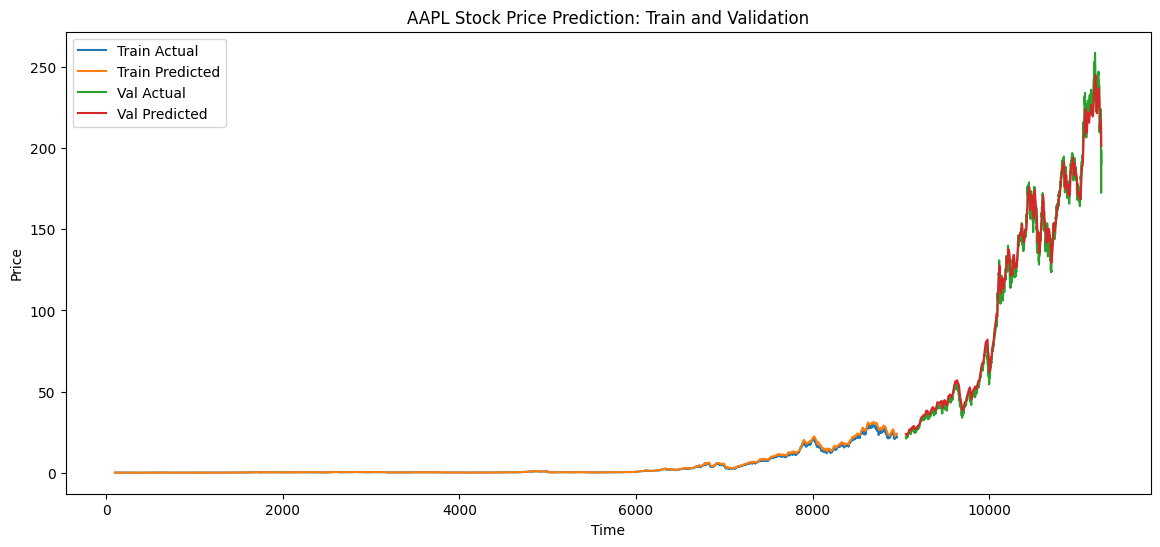

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('AAPL1.csv')
df = df.dropna()
df = df.iloc[2:]  # Remove first two rows if needed
data = df['Close'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Hyperparameters
lookback = 100

# Prepare sequences
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Reshape for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

# Predict
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
val_predict = scaler.inverse_transform(val_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

# Plot
plt.figure(figsize=(14,6))
plt.plot(range(lookback, lookback + len(y_train_actual)), y_train_actual, label='Train Actual')
plt.plot(range(lookback, lookback + len(train_predict)), train_predict, label='Train Predicted')
plt.plot(range(len(y_train_actual) + 2*lookback, len(y_train_actual) + 2*lookback + len(y_val_actual)), y_val_actual, label='Val Actual')
plt.plot(range(len(y_train_actual) + 2*lookback, len(y_train_actual) + 2*lookback + len(val_predict)), val_predict, label='Val Predicted')
plt.title('AAPL Stock Price Prediction: Train and Validation')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Evaluate accuracy
mse = mean_squared_error(y_val_actual, val_predict)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_val_actual, val_predict)
r2 = r2_score(y_val_actual, val_predict)

print(f"📊 Evaluation Metrics:")
print(f" - RMSE: {rmse}")
print(f" - MAE : {mae}")
print(f" - R²   : {r2}")


📊 Evaluation Metrics:
 - RMSE: 5.041676140528363
 - MAE : 3.6959173835427173
 - R²   : 0.9942550448225465


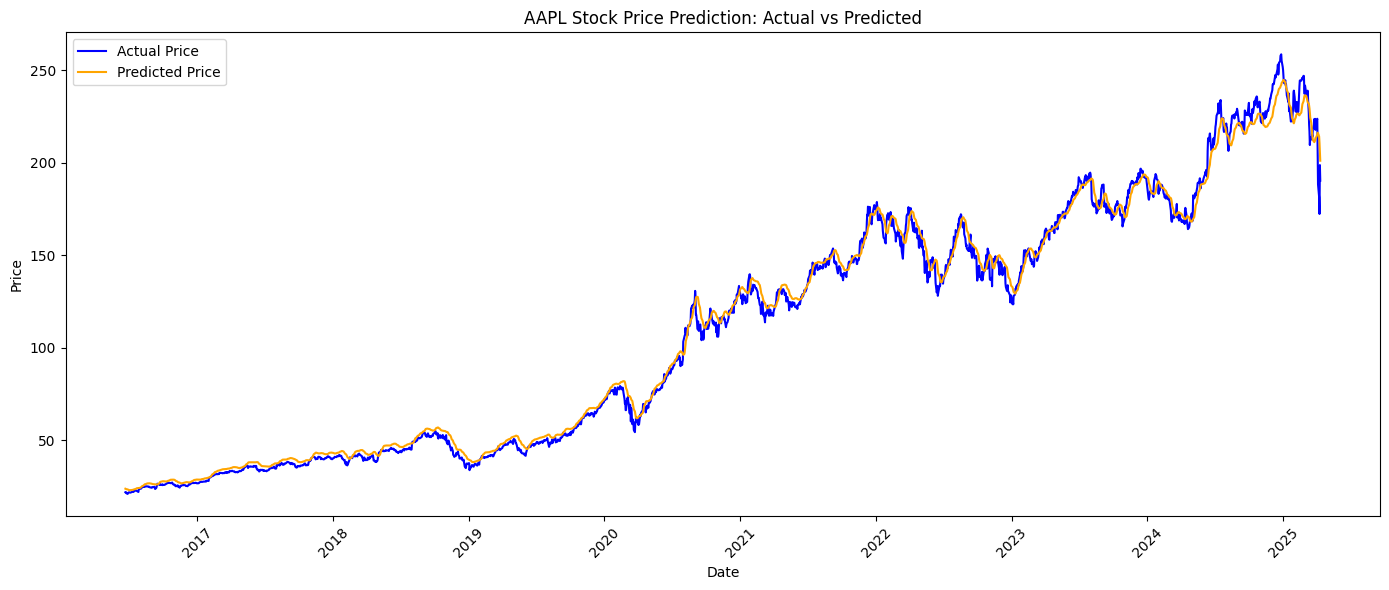

In [4]:
# Extract the dates
dates = pd.to_datetime(df['Price'].values)
val_dates = dates[-len(y_val_actual):]

# Plot with dates
plt.figure(figsize=(14,6))
plt.plot(val_dates, y_val_actual, label='Actual Price', color='blue')
plt.plot(val_dates, val_predict, label='Predicted Price', color='orange')
plt.title("AAPL Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Save model architecture and weights
model.save("aapl_lstm_model.h5")
print("✅ Model saved as aapl_lstm_model.h5")


✅ Model saved as aapl_lstm_model.h5


In [6]:
#to load later
#from tensorflow.keras.models import load_model
#model = load_model("aapl_lstm_model.h5")

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Extract 'Close' column and reshape
close_prices = df[['Close']].values  # Assuming df is your full dataframe

# Fit the scaler on 'Close' prices`
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)


In [32]:
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [33]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']].values)

In [34]:
future_input = scaled_data[-60:].reshape(1, 60, 1)  # Last 60 values
future_predictions = []

for _ in range(10):
    pred = model.predict(future_input)[0][0]
    future_predictions.append(pred)
    
    # Append prediction and slide window
    future_input = np.append(future_input[:,1:,:], [[[pred]]], axis=1)

# Inverse transform predictions to get actual price
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [35]:
future_predictions_actual

array([[197.23051],
       [194.38281],
       [192.54274],
       [191.42906],
       [190.7732 ],
       [190.37637],
       [190.11192],
       [189.9078 ],
       [189.72804],
       [189.55667]], dtype=float32)

In [36]:
import pandas as pd
from datetime import datetime, timedelta

# Ensure your Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define start and end dates
start_date = pd.to_datetime('2024-04-01')
end_date = datetime.today() - timedelta(days=1)

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Optional: Reset index
filtered_df = filtered_df.reset_index(drop=True)

# Display the new DataFrame
print(filtered_df.tail())


          Price       Close                High                 Low  \
254  2025-04-04  188.380005   199.8800048828125  187.33999633789062   
255  2025-04-07  181.460007  194.14999389648438   174.6199951171875   
256  2025-04-08  172.419998  190.33999633789062   169.2100067138672   
257  2025-04-09  198.850006  200.61000061035156  171.88999938964844   
258  2025-04-10  190.419998  194.77999877929688               183.0   

                   Open     Volume       Date  
254  193.88999938964844  125910900 2025-04-04  
255   177.1999969482422  160466300 2025-04-07  
256   186.6999969482422  120859500 2025-04-08  
257   171.9499969482422  184395900 2025-04-09  
258  189.07000732421875  121685000 2025-04-10  


In [37]:
filtered_df = filtered_df.drop(columns=['Price'])

In [38]:
filtered_df

,Close,High,Low,Open,Volume,Date
0,169.230927,170.4451942217802,168.68350825393796,170.38547862745995,46240500,2024-04-01
1,168.046494,168.54414366405445,167.43935975957754,168.28537106183597,49329500,2024-04-02
2,168.852707,169.87786510696628,167.78774337767854,167.9967479570679,47691700,2024-04-03
3,168.026611,171.11203328162168,168.026611328125,169.48968886138192,53704400,2024-04-04
4,168.783035,169.5892261323792,168.15599119757314,168.79298281447828,42055200,2024-04-05
...,...,...,...,...,...,...
254,188.380005,199.8800048828125,187.33999633789062,193.88999938964844,125910900,2025-04-04
255,181.460007,194.14999389648438,174.6199951171875,177.1999969482422,160466300,2025-04-07
256,172.419998,190.33999633789062,169.2100067138672,186.6999969482422,120859500,2025-04-08
257,198.850006,200.61000061035156,171.88999938964844,171.9499969482422,184395900,2025-04-09


In [39]:
filtered_df.to_csv("aapl_filtered_apr2024_to_apr2025.csv", index=False)

In [40]:
# Convert Date column to datetime and format as "Mon D"
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
filtered_df['formatted_date'] = filtered_df['Date'].dt.strftime('%b %-d')

# Calculate 7-day and 30-day moving averages on Close
filtered_df['ma7'] = filtered_df['Close'].rolling(window=7).mean()
filtered_df['ma30'] = filtered_df['Close'].rolling(window=30).mean()

# Drop rows with NaN values in MA columns to keep output clean
filtered_df_clean = filtered_df.dropna(subset=['ma7', 'ma30'])

# Create JS-style objects
price_data = [{'date': row['formatted_date'], 'price': round(row['Close'], 2)} for _, row in filtered_df.iterrows()]
volume_data = [{'date': row['formatted_date'], 'volume': int(row['Volume'])} for _, row in filtered_df.iterrows()]
ma_data = [{'date': row['formatted_date'], 'price': round(row['Close'], 2),
            'ma7': round(row['ma7'], 2), 'ma30': round(row['ma30'], 2)} for _, row in filtered_df_clean.iterrows()]

price_data[:3], volume_data[:3], ma_data[:3]  # Show a preview


([{'date': '2024-04-01 00:00:00', 'price': 169.23},
  {'date': '2024-04-02 00:00:00', 'price': 168.05},
  {'date': '2024-04-03 00:00:00', 'price': 168.85}],
 [{'date': '2024-04-01 00:00:00', 'volume': 46240500},
  {'date': '2024-04-02 00:00:00', 'volume': 49329500},
  {'date': '2024-04-03 00:00:00', 'volume': 47691700}],
 [{'date': '2024-05-10 00:00:00',
   'price': 182.44,
   'ma7': 180.74,
   'ma30': 171.58},
  {'date': '2024-05-13 00:00:00',
   'price': 185.66,
   'ma7': 182.66,
   'ma30': 172.13},
  {'date': '2024-05-14 00:00:00',
   'price': 186.8,
   'ma7': 183.27,
   'ma30': 172.75}])

In [41]:
# Load the filtered dataframe from April 2024 to April 2025
df = pd.read_csv("aapl_filtered_apr2024_to_apr2025.csv", parse_dates=["Date"])
df["Month"] = df["Date"].dt.month
df["MonthName"] = df["Date"].dt.strftime("%b")
df["Day"] = df["Date"].dt.day

# Group by month and sample 3 random dates from each month
sampled_df = df.groupby(["Month", "MonthName"]).apply(lambda x: x.sample(n=3, random_state=42)).reset_index(drop=True)
sampled_df = sampled_df.sort_values(by="Date")  # Sort by actual date for correct ordering

# Convert to MMM D format for frontend
sampled_df["formatted_date"] = sampled_df["Date"].dt.strftime("%b %-d")

# Build the priceData and volumeData
price_data = [{"date": row["formatted_date"], "price": round(row["Close"], 2)} for _, row in sampled_df.iterrows()]
volume_data = [{"date": row["formatted_date"], "volume": int(row["Volume"])} for _, row in sampled_df.iterrows()]

price_data, volume_data

C:\Users\adria\AppData\Local\Temp\ipykernel_5316\558468786.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(["Month", "MonthName"]).apply(lambda x: x.sample(n=3, random_state=42)).reset_index(drop=True)


([{'date': '2024-04-22 00:00:00', 'price': 165.06},
  {'date': '2024-05-01 00:00:00', 'price': 168.5},
  {'date': '2024-05-13 00:00:00', 'price': 185.66},
  {'date': '2024-05-20 00:00:00', 'price': 190.4},
  {'date': '2024-06-03 00:00:00', 'price': 193.38},
  {'date': '2024-06-10 00:00:00', 'price': 192.47},
  {'date': '2024-06-18 00:00:00', 'price': 213.57},
  {'date': '2024-07-01 00:00:00', 'price': 216.02},
  {'date': '2024-07-12 00:00:00', 'price': 229.77},
  {'date': '2024-07-19 00:00:00', 'price': 223.56},
  {'date': '2024-08-01 00:00:00', 'price': 217.63},
  {'date': '2024-08-13 00:00:00', 'price': 220.78},
  {'date': '2024-08-20 00:00:00', 'price': 226.01},
  {'date': '2024-09-03 00:00:00', 'price': 222.28},
  {'date': '2024-09-24 00:00:00', 'price': 226.87},
  {'date': '2024-09-26 00:00:00', 'price': 227.02},
  {'date': '2024-10-01 00:00:00', 'price': 225.71},
  {'date': '2024-10-14 00:00:00', 'price': 230.79},
  {'date': '2024-10-22 00:00:00', 'price': 235.34},
  {'date': '20